In [ ]:
# ================================================
# Step 1: Install dependencies
# ================================================
!pip install torch torchvision torchaudio --quiet
!pip install pycocotools --quiet

import torch, torchvision
print("Torch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())


Torch version: 2.8.0+cu126
CUDA available: True


In [ ]:
!pip install torchmetrics[image] -q


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 26.8 MB/s eta 0:00:00


In [ ]:
import os, random, zipfile, json, time, warnings
from google.colab import drive
drive.mount('/content/drive')

zip_path = "/content/drive/MyDrive/VOC_dataset1.zip"   # 👈 path to your zipped dataset
extract_dir = "/content/dataset"

if not os.path.exists(extract_dir):
    os.makedirs(extract_dir, exist_ok=True)

print(f"Extracting {zip_path} -> {extract_dir} ...")
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)
print("✅ Extraction done.")

Mounted at /content/drive
Extracting /content/drive/MyDrive/VOC_dataset1.zip -> /content/dataset ...
✅ Extraction done.


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Extracting /content/drive/MyDrive/VOC_dataset1.zip -> /content/dataset ...
✅ Extraction done.
📂 VOC root: /content/dataset/VOC_dataset1
Classes: {'0': 1, '10': 2, '11': 3, '12': 4, '13': 5, '14': 6, '15': 7, '16': 8, '17': 9, '18': 10, '19': 11, '1': 12, '20': 13, '21': 14, '22': 15, '23': 16, '24': 17, '25': 18, '26': 19, '27': 20, '28': 21, '29': 22, '2': 23, '30': 24, '31': 25, '32': 26, '33': 27, '34': 28, '35': 29, '36': 30, '37': 31, '38': 32, '39': 33, '3': 34, '40': 35, '41': 36, '42': 37, '4': 38, '5': 39, '6': 40, '7': 41, '8': 42, '9': 43}


/tmp/ipython-input-4119801463.py:183: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()  # mixed precision


🔄 Resumed from epoch 21


Epoch 22/25:   0%|          | 0/3500 [00:00<?, ?it/s]/tmp/ipython-input-4119801463.py:205: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 22/25: 100%|██████████| 3500/3500 [14:24<00:00,  4.05it/s, loss=0.0720]


📊 Epoch 22: mAP=0.8819, mAP50=0.9840
🌟 New best mAP=0.8819, model saved
💾 Checkpoint saved (epoch 22)


Epoch 23/25: 100%|██████████| 3500/3500 [14:27<00:00,  4.04it/s, loss=0.0720]


📊 Epoch 23: mAP=0.8819, mAP50=0.9840
⏳ Patience 1/5
💾 Checkpoint saved (epoch 23)


Epoch 24/25: 100%|██████████| 3500/3500 [14:29<00:00,  4.03it/s, loss=0.0720]


📊 Epoch 24: mAP=0.8819, mAP50=0.9840
⏳ Patience 2/5
💾 Checkpoint saved (epoch 24)


Epoch 25/25: 100%|██████████| 3500/3500 [14:29<00:00,  4.03it/s, loss=0.0720]


📊 Epoch 25: mAP=0.8819, mAP50=0.9840
⏳ Patience 3/5
💾 Checkpoint saved (epoch 25)
✅ Training finished, model + label_map saved to Drive


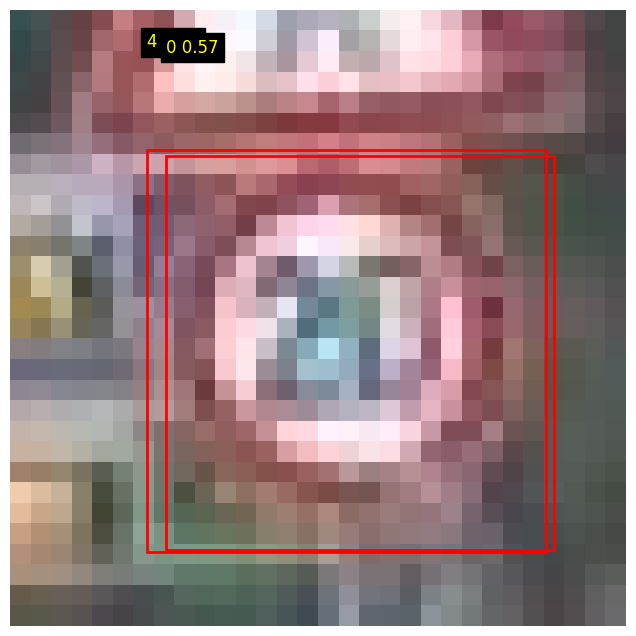

In [ ]:
# ================================================
# Step 0: Mount Google Drive
# ================================================
from google.colab import drive
drive.mount('/content/drive')

# ================================================
# Step 1: Imports
# ================================================
import os, random, zipfile, json, time, warnings
import xml.etree.ElementTree as ET
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from tqdm import tqdm

from torchvision.models.detection import maskrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchmetrics.detection.mean_ap import MeanAveragePrecision

random.seed(42)

# ================================================
# Step 2: Extract Dataset (VOC_dataset.zip uploaded to Drive)
# ================================================
zip_path = "/content/drive/MyDrive/VOC_dataset1.zip"   # 👈 path to your zipped dataset
extract_dir = "/content/dataset"

if not os.path.exists(extract_dir):
    os.makedirs(extract_dir, exist_ok=True)

print(f"Extracting {zip_path} -> {extract_dir} ...")
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)
print("✅ Extraction done.")

# Detect VOC root
voc_root = None
for root, dirs, files in os.walk(extract_dir):
    if "JPEGImages" in dirs and "Annotations" in dirs and "ImageSets" in dirs:
        voc_root = root
        break

if voc_root is None:
    raise FileNotFoundError("❌ VOC structure not found")

images_dir = os.path.join(voc_root, "JPEGImages")
annotations_dir = os.path.join(voc_root, "Annotations")
split_dir = os.path.join(voc_root, "ImageSets", "Main")

print("📂 VOC root:", voc_root)

# ================================================
# Step 3: Dataset Loader
# ================================================
class VOCDataset(Dataset):
    def __init__(self, images_dir, annotations_dir, split_file, transforms=None, min_box_area=16):
        self.images_dir = images_dir
        self.annotations_dir = annotations_dir
        self.transforms = transforms
        self.min_box_area = min_box_area

        with open(split_file, "r") as f:
            basenames = [line.strip() for line in f if line.strip()]

        self.image_files = []
        for base in basenames:
            for ext in (".jpg", ".jpeg", ".png"):
                cand = base + ext
                if os.path.exists(os.path.join(images_dir, cand)):
                    self.image_files.append(cand)
                    break

        # Build label map from XMLs
        self.label_map = {}
        next_id = 1
        for img_fn in self.image_files:
            xml_path = os.path.join(annotations_dir, os.path.splitext(img_fn)[0] + ".xml")
            if not os.path.exists(xml_path): continue
            tree = ET.parse(xml_path)
            for obj in tree.findall("object"):
                name = obj.find("name").text.strip()
                if name not in self.label_map:
                    self.label_map[name] = next_id
                    next_id += 1
        if not self.label_map:
            self.label_map = {"traffic_sign": 1}
        self.id2name = {v: k for k, v in self.label_map.items()}

    def __len__(self): return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.images_dir, img_name)
        xml_path = os.path.join(self.annotations_dir, os.path.splitext(img_name)[0] + ".xml")

        img = Image.open(img_path).convert("RGB")
        w, h = img.size

        boxes, labels, iscrowd, masks = [], [], [], []
        if os.path.exists(xml_path):
            tree = ET.parse(xml_path)
            for obj in tree.findall("object"):
                name = obj.find("name").text.strip()
                if name not in self.label_map: continue
                xmlbox = obj.find("bndbox")
                xmin, ymin, xmax, ymax = map(float, [
                    xmlbox.find("xmin").text,
                    xmlbox.find("ymin").text,
                    xmlbox.find("xmax").text,
                    xmlbox.find("ymax").text
                ])
                xmin, ymin = max(0, xmin), max(0, ymin)
                xmax, ymax = min(w-1, xmax), min(h-1, ymax)
                area = (xmax-xmin)*(ymax-ymin)
                if area < self.min_box_area: continue
                boxes.append([xmin, ymin, xmax, ymax])
                labels.append(self.label_map[name])
                iscrowd.append(0)
                mask = torch.zeros((h, w), dtype=torch.uint8)
                mask[int(ymin):int(ymax), int(xmin):int(xmax)] = 1
                masks.append(mask)

        if not boxes:
            boxes = torch.zeros((0,4), dtype=torch.float32)
            labels = torch.zeros((0,), dtype=torch.int64)
            masks = torch.zeros((0,h,w), dtype=torch.uint8)
            area = torch.zeros((0,), dtype=torch.float32)
            iscrowd = torch.zeros((0,), dtype=torch.int64)
        else:
            boxes = torch.tensor(boxes, dtype=torch.float32)
            labels = torch.tensor(labels, dtype=torch.int64)
            masks = torch.stack(masks, dim=0)
            area = (boxes[:,3]-boxes[:,1])*(boxes[:,2]-boxes[:,0])
            iscrowd = torch.tensor(iscrowd, dtype=torch.int64)

        target = {"boxes": boxes, "labels": labels, "masks": masks,
                  "image_id": torch.tensor([idx]), "area": area, "iscrowd": iscrowd}
        img = TF.to_tensor(img)
        return img, target

def collate_fn(batch): return tuple(zip(*batch))

# ================================================
# Step 4: Datasets & Loaders
# ================================================
train_ds = VOCDataset(images_dir, annotations_dir, os.path.join(split_dir, "train.txt"))
val_ds   = VOCDataset(images_dir, annotations_dir, os.path.join(split_dir, "val.txt"))

train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, collate_fn=collate_fn)
val_loader   = DataLoader(val_ds, batch_size=2, shuffle=False, collate_fn=collate_fn)

print("Classes:", train_ds.label_map)

# ================================================
# Step 5: Model
# ================================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = maskrcnn_resnet50_fpn(weights="DEFAULT")
num_classes = 1 + len(train_ds.label_map)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, 256, num_classes)
model.to(device)

# ================================================
# Step 6: Training Loop with Auto-Resume + Mixed Precision
# ================================================
CHECKPOINT_DIR = "/content/drive/MyDrive/GTSDB_Checkpoints"
os.makedirs(CHECKPOINT_DIR, exist_ok=True)
CHECKPOINT_PATH = os.path.join(CHECKPOINT_DIR, "checkpoint.pth")
FINAL_MODEL_PATH = os.path.join(CHECKPOINT_DIR, "final_model.pth")
LABEL_MAP_PATH = os.path.join(CHECKPOINT_DIR, "label_map.json")

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
scaler = torch.cuda.amp.GradScaler()  # mixed precision

start_epoch, best_map, patience, patience_counter = 0, 0.0, 5, 0

if os.path.exists(CHECKPOINT_PATH):
    ckpt = torch.load(CHECKPOINT_PATH, map_location=device)
    model.load_state_dict(ckpt["model"])
    optimizer.load_state_dict(ckpt["optimizer"])
    lr_scheduler.load_state_dict(ckpt["lr_scheduler"])
    start_epoch = ckpt["epoch"]+1
    print(f"🔄 Resumed from epoch {start_epoch}")

num_epochs = 25
for epoch in range(start_epoch, num_epochs):
    model.train()
    loss_sum = 0
    progress = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")

    for images, targets in progress:
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k,v in t.items()} for t in targets]

        with torch.cuda.amp.autocast():
            loss_dict = model(images, targets)
            loss = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        loss_sum += loss.item()
        avg_loss = loss_sum / (progress.n + 1)
        progress.set_postfix({"loss": f"{avg_loss:.4f}"})

    lr_scheduler.step()

    # Validation (mAP)
    metric = MeanAveragePrecision()
    model.eval()
    with torch.no_grad():
        for images, targets in val_loader:
            images = [img.to(device) for img in images]
            outputs = model(images)
            gt = [{"boxes": t["boxes"].cpu(), "labels": t["labels"].cpu()} for t in targets]
            preds = [{"boxes": o["boxes"].cpu(), "scores": o["scores"].cpu(), "labels": o["labels"].cpu()} for o in outputs]
            metric.update(preds, gt)
    results = metric.compute()
    print(f"📊 Epoch {epoch+1}: mAP={results['map']:.4f}, mAP50={results['map_50']:.4f}")

    # Early stopping + save best
    if results["map"] > best_map:
        best_map = results["map"]
        patience_counter = 0
        torch.save(model.state_dict(), FINAL_MODEL_PATH)
        print(f"🌟 New best mAP={best_map:.4f}, model saved")
    else:
        patience_counter += 1
        print(f"⏳ Patience {patience_counter}/{patience}")
        if patience_counter >= patience:
            print("🛑 Early stopping triggered")
            break

    # Save checkpoint
    torch.save({"epoch": epoch,
                "model": model.state_dict(),
                "optimizer": optimizer.state_dict(),
                "lr_scheduler": lr_scheduler.state_dict()},
                CHECKPOINT_PATH)
    print(f"💾 Checkpoint saved (epoch {epoch+1})")

with open(LABEL_MAP_PATH,"w") as f: json.dump(train_ds.label_map,f)
print("✅ Training finished, model + label_map saved to Drive")

# ================================================
# Step 7: Inference Example
# ================================================
model.eval()
img, _ = val_ds[0]
with torch.no_grad():
    pred = model([img.to(device)])[0]

img_np = img.mul(255).permute(1,2,0).byte().numpy()
fig, ax = plt.subplots(1, figsize=(12,8))
ax.imshow(img_np)

for box, score, label in zip(pred["boxes"].cpu(), pred["scores"].cpu(), pred["labels"].cpu()):
    if score > 0.5:
        x1,y1,x2,y2 = box.numpy()
        rect = patches.Rectangle((x1,y1), x2-x1, y2-y1, linewidth=2, edgecolor="r", facecolor="none")
        ax.add_patch(rect)
        cls = val_ds.id2name.get(int(label.item()), "sign")
        ax.text(x1,y1-5,f"{cls} {score:.2f}", color="yellow", fontsize=12, backgroundcolor="black")
plt.axis("off")
plt.show()


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 199MB/s]


✅ Model loaded and validation loader ready.
📊 Generating confusion matrix (this may take a while)...


100%|██████████| 1000/1000 [03:10<00:00,  5.26it/s]


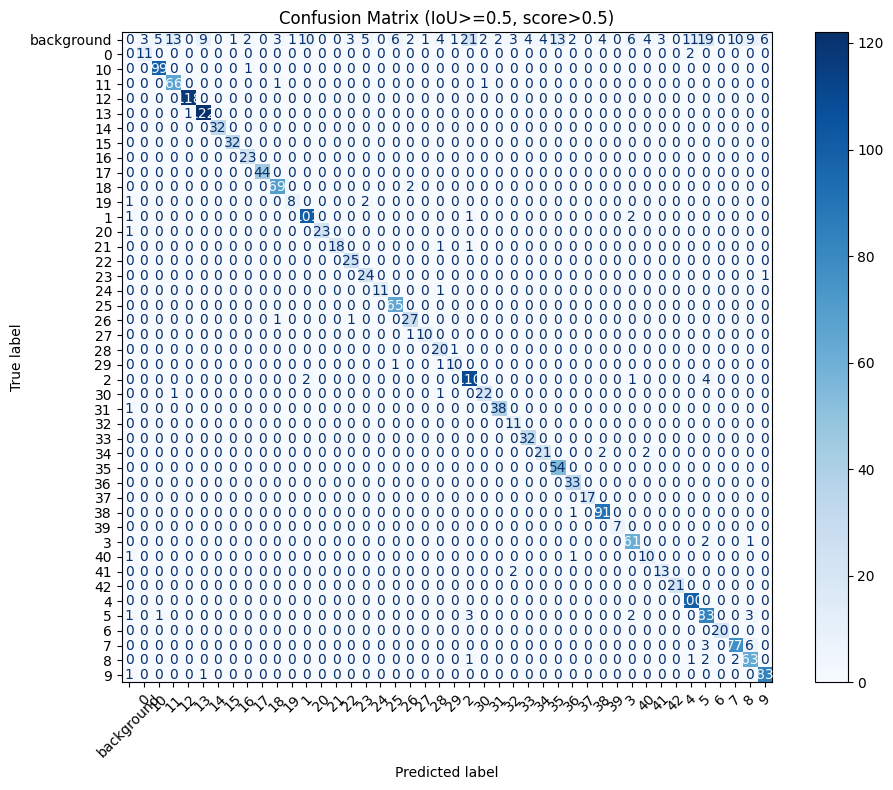

✅ Confusion matrix saved to /content/drive/MyDrive/GTSDB_Checkpoints/confusion_matrix.png


In [ ]:
# === Redefine dataset, recreate val_loader, load model weights, then compute confusion matrix ===
import os, torch, xml.etree.ElementTree as ET
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms.functional as TF
from torchvision.models.detection import maskrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

# --- Redefine VOCDataset (same as your main script) ---
class VOCDataset(Dataset):
    def __init__(self, images_dir, annotations_dir, split_file, transforms=None, min_box_area=16):
        self.images_dir = images_dir
        self.annotations_dir = annotations_dir
        self.transforms = transforms
        self.min_box_area = min_box_area

        with open(split_file, "r") as f:
            basenames = [line.strip() for line in f if line.strip()]

        self.image_files = []
        for base in basenames:
            for ext in (".jpg", ".jpeg", ".png"):
                cand = base + ext
                if os.path.exists(os.path.join(images_dir, cand)):
                    self.image_files.append(cand)
                    break

        self.label_map = {}
        next_id = 1
        for img_fn in self.image_files:
            xml_path = os.path.join(annotations_dir, os.path.splitext(img_fn)[0] + ".xml")
            if not os.path.exists(xml_path): continue
            tree = ET.parse(xml_path)
            for obj in tree.findall("object"):
                name = obj.find("name").text.strip()
                if name not in self.label_map:
                    self.label_map[name] = next_id
                    next_id += 1
        if not self.label_map:
            self.label_map = {"traffic_sign": 1}
        self.id2name = {v: k for k, v in self.label_map.items()}

    def __len__(self): return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.images_dir, img_name)
        xml_path = os.path.join(self.annotations_dir, os.path.splitext(img_name)[0] + ".xml")

        img = Image.open(img_path).convert("RGB")
        w, h = img.size

        boxes, labels, iscrowd, masks = [], [], [], []
        if os.path.exists(xml_path):
            tree = ET.parse(xml_path)
            for obj in tree.findall("object"):
                name = obj.find("name").text.strip()
                if name not in self.label_map: continue
                xmlbox = obj.find("bndbox")
                xmin, ymin, xmax, ymax = map(float, [
                    xmlbox.find("xmin").text,
                    xmlbox.find("ymin").text,
                    xmlbox.find("xmax").text,
                    xmlbox.find("ymax").text
                ])
                xmin, ymin = max(0, xmin), max(0, ymin)
                xmax, ymax = min(w-1, xmax), min(h-1, ymax)
                area = (xmax-xmin)*(ymax-ymin)
                if area < self.min_box_area: continue
                boxes.append([xmin, ymin, xmax, ymax])
                labels.append(self.label_map[name])
                iscrowd.append(0)
                mask = torch.zeros((h, w), dtype=torch.uint8)
                mask[int(ymin):int(ymax), int(xmin):int(xmax)] = 1
                masks.append(mask)

        if not boxes:
            boxes = torch.zeros((0,4), dtype=torch.float32)
            labels = torch.zeros((0,), dtype=torch.int64)
            masks = torch.zeros((0,h,w), dtype=torch.uint8)
            area = torch.zeros((0,), dtype=torch.float32)
            iscrowd = torch.zeros((0,), dtype=torch.int64)
        else:
            boxes = torch.tensor(boxes, dtype=torch.float32)
            labels = torch.tensor(labels, dtype=torch.int64)
            masks = torch.stack(masks, dim=0)
            area = (boxes[:,3]-boxes[:,1])*(boxes[:,2]-boxes[:,0])
            iscrowd = torch.tensor(iscrowd, dtype=torch.int64)

        target = {"boxes": boxes, "labels": labels, "masks": masks,
                  "image_id": torch.tensor([idx]), "area": area, "iscrowd": iscrowd}
        img = TF.to_tensor(img)
        return img, target

def collate_fn(batch): return tuple(zip(*batch))

# --- Paths (adjust if your folder names differ) ---
voc_root = "/content/dataset"  # the parent folder where your ZIP was extracted
# detect voc_root if needed (optional)
for root, dirs, files in os.walk(voc_root):
    if "JPEGImages" in dirs and "Annotations" in dirs and "ImageSets" in dirs:
        voc_root = root
        break

images_dir = os.path.join(voc_root, "JPEGImages")
annotations_dir = os.path.join(voc_root, "Annotations")
split_dir = os.path.join(voc_root, "ImageSets", "Main")

# --- Recreate validation dataset & loader ---
val_ds = VOCDataset(images_dir, annotations_dir, os.path.join(split_dir, "val.txt"))
val_loader = DataLoader(val_ds, batch_size=2, shuffle=False, collate_fn=collate_fn)

# --- Rebuild model and load weights ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = maskrcnn_resnet50_fpn(weights=None)
num_classes = 1 + len(val_ds.label_map)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, 256, num_classes)

model_path = "/content/drive/MyDrive/GTSDB_Checkpoints/final_model.pth"
state = torch.load(model_path, map_location=device)
model.load_state_dict(state)
model.to(device)
model.eval()
print("✅ Model loaded and validation loader ready.")

# --- Now compute confusion matrix (same logic as Option A) ---
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from torchvision.ops import box_iou
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

iou_threshold = 0.5
score_thresh = 0.5
normalize = False

all_gt_labels = []
all_pred_labels = []

print("📊 Generating confusion matrix (this may take a while)...")
with torch.no_grad():
    for images, targets in tqdm(val_loader):
        images = [img.to(device) for img in images]
        outputs = model(images)

        for output, target in zip(outputs, targets):
            gt_boxes = target["boxes"].cpu()
            gt_labels = target["labels"].cpu().numpy()

            pred_boxes = output["boxes"].cpu()
            pred_labels = output["labels"].cpu().numpy()
            pred_scores = output["scores"].cpu().numpy()

            keep_idx = pred_scores > score_thresh
            pred_boxes = pred_boxes[keep_idx]
            pred_labels = pred_labels[keep_idx]

            if len(gt_boxes) == 0 and len(pred_boxes) == 0:
                continue
            elif len(gt_boxes) == 0:
                all_pred_labels.extend(pred_labels.tolist())
                all_gt_labels.extend([0]*len(pred_labels))
            elif len(pred_boxes) == 0:
                all_pred_labels.extend([0]*len(gt_boxes))
                all_gt_labels.extend(gt_labels.tolist())
            else:
                ious = box_iou(pred_boxes, gt_boxes)
                max_iou, gt_idx = ious.max(dim=1)
                matched_gt = set()
                for i, (iou, gti) in enumerate(zip(max_iou, gt_idx)):
                    if iou >= iou_threshold and gti.item() not in matched_gt:
                        all_gt_labels.append(int(gt_labels[gti]))
                        all_pred_labels.append(int(pred_labels[i]))
                        matched_gt.add(gti.item())
                    else:
                        all_gt_labels.append(0)
                        all_pred_labels.append(int(pred_labels[i]))
                for j in range(len(gt_boxes)):
                    if j not in matched_gt:
                        all_gt_labels.append(int(gt_labels[j]))
                        all_pred_labels.append(0)

cm_labels = [0] + list(val_ds.label_map.values())
display_labels = ["background"] + list(val_ds.label_map.keys())

cm = confusion_matrix(all_gt_labels, all_pred_labels, labels=cm_labels)
if normalize:
    cm = cm.astype('float') / (cm.sum(axis=1, keepdims=True) + 1e-12)

fig, ax = plt.subplots(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
disp.plot(ax=ax, xticks_rotation=45, cmap='Blues', values_format='.2f' if normalize else 'd')
plt.title(f"Confusion Matrix (IoU>={iou_threshold}, score>{score_thresh})")
plt.tight_layout()
plt.show()

save_path = "/content/drive/MyDrive/GTSDB_Checkpoints/confusion_matrix.png"
fig.savefig(save_path)
print("✅ Confusion matrix saved to", save_path)


📈 Generating YOLO-style Confidence and PR curves for Mask R-CNN...


/tmp/ipython-input-54407805.py:70: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


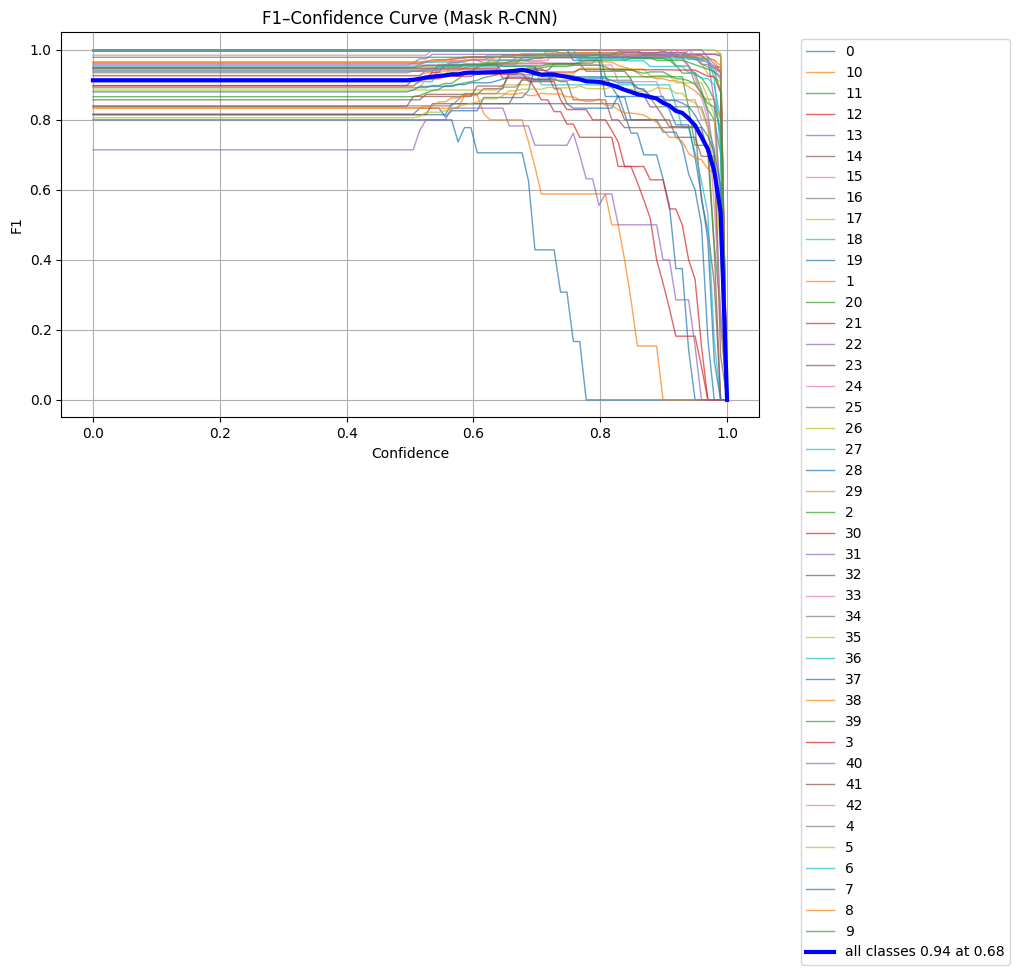

/tmp/ipython-input-54407805.py:86: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


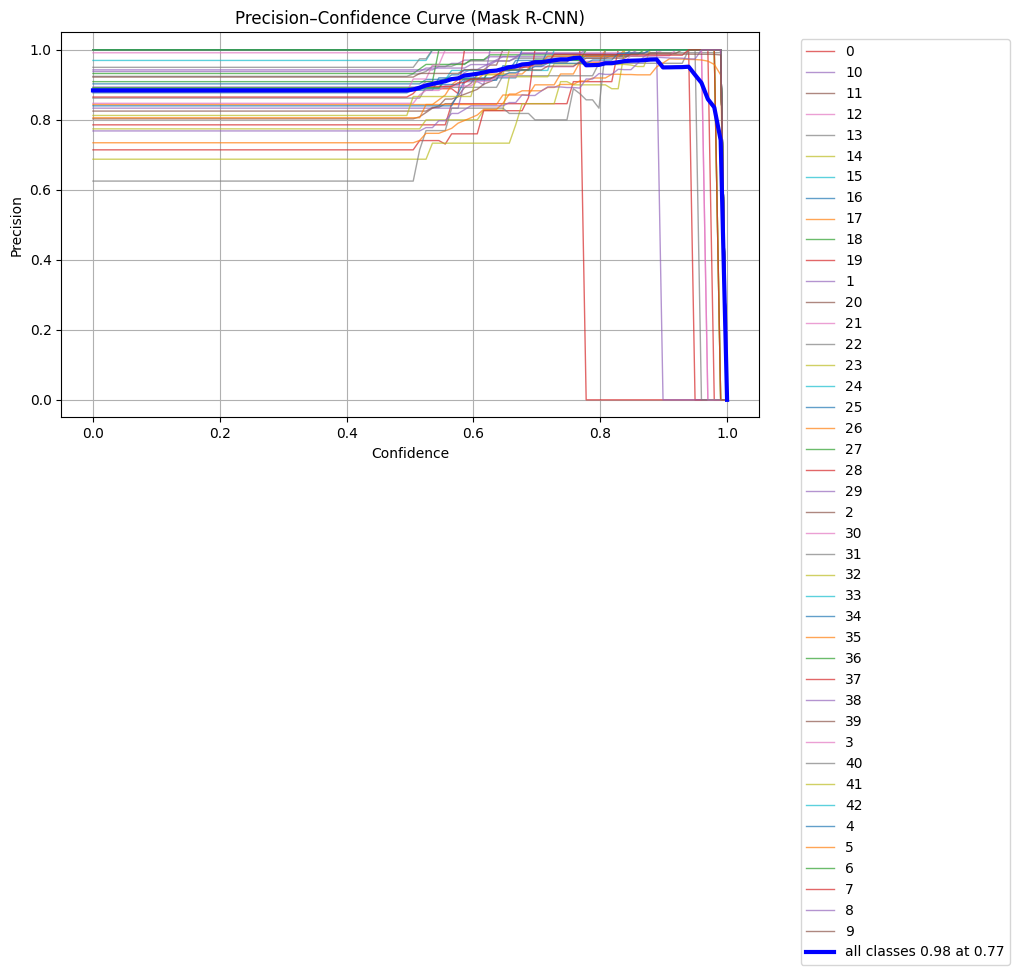

/tmp/ipython-input-54407805.py:102: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


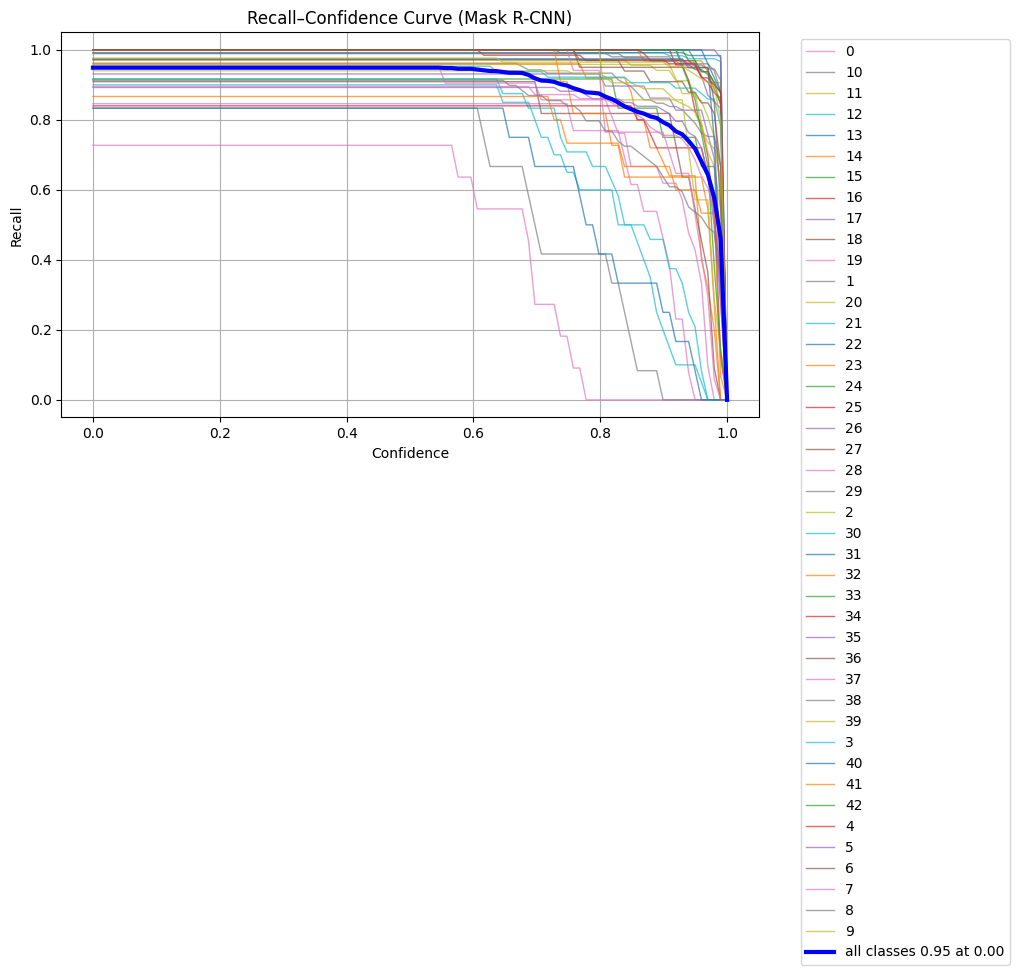

/tmp/ipython-input-54407805.py:127: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


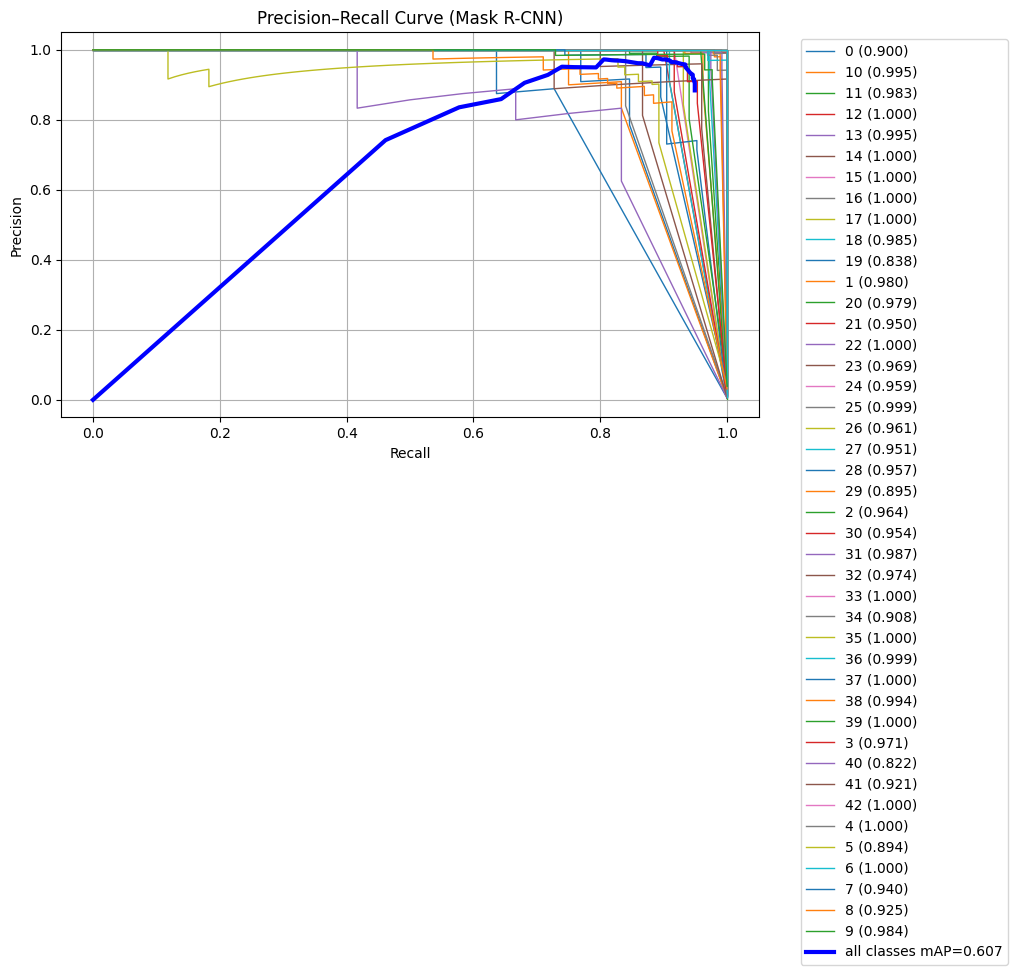

✅ Saved all plots to /content/drive/MyDrive/GTSDB_Checkpoints/


<Figure size 640x480 with 0 Axes>

In [ ]:
# ==========================================================
# Confidence Curves for Mask R-CNN
# ==========================================================
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.metrics import precision_recall_curve, auc

# all_gt_labels, all_pred_labels, all_pred_scores, display_labels must exist from earlier
print("📈 Generating YOLO-style Confidence and PR curves for Mask R-CNN...")

n_classes = len(display_labels)
conf_thresholds = np.linspace(0, 1, 100)

precision_curve = np.zeros((n_classes, len(conf_thresholds)))
recall_curve = np.zeros((n_classes, len(conf_thresholds)))
f1_curve = np.zeros((n_classes, len(conf_thresholds)))

y_true = np.array(all_gt_labels)
y_pred = np.array(all_pred_labels)
y_score = np.array(all_pred_scores)

# ---- Compute per-class curves ----
for ci in range(1, n_classes):  # skip background (0)
    class_name = display_labels[ci]
    gt_mask = (y_true == ci)
    for i, conf in enumerate(conf_thresholds):
        pred_mask = (y_score >= conf)
        pred_cls = (y_pred == ci) & pred_mask

        tp = np.sum(gt_mask & pred_cls)
        fp = np.sum(~gt_mask & pred_cls)
        fn = np.sum(gt_mask & ~pred_cls)

        precision = tp / (tp + fp + 1e-16)
        recall = tp / (tp + fn + 1e-16)
        f1 = 2 * precision * recall / (precision + recall + 1e-16)

        precision_curve[ci, i] = precision
        recall_curve[ci, i] = recall
        f1_curve[ci, i] = f1

# ---- Mean curves across all classes ----
mean_precision = np.mean(precision_curve[1:], axis=0)
mean_recall = np.mean(recall_curve[1:], axis=0)
mean_f1 = np.mean(f1_curve[1:], axis=0)

best_conf_f1 = conf_thresholds[np.argmax(mean_f1)]
best_f1 = np.max(mean_f1)
best_conf_p = conf_thresholds[np.argmax(mean_precision)]
best_p = np.max(mean_precision)
best_conf_r = conf_thresholds[np.argmax(mean_recall)]
best_r = np.max(mean_recall)

colors = cycle(plt.cm.tab10.colors)

# ----------------------------------------------------------
# F1-Confidence Curve
# ----------------------------------------------------------
plt.figure(figsize=(9, 5))
for ci, c in zip(range(1, n_classes), colors):
    plt.plot(conf_thresholds, f1_curve[ci], color=c, lw=1, alpha=0.7, label=display_labels[ci])
plt.plot(conf_thresholds, mean_f1, color='blue', lw=3,
         label=f"all classes {best_f1:.2f} at {best_conf_f1:.2f}")
plt.xlabel("Confidence")
plt.ylabel("F1")
plt.title("F1–Confidence Curve (Mask R-CNN)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

# ----------------------------------------------------------
# Precision–Confidence Curve
# ----------------------------------------------------------
plt.figure(figsize=(9, 5))
for ci, c in zip(range(1, n_classes), colors):
    plt.plot(conf_thresholds, precision_curve[ci], color=c, lw=1, alpha=0.7, label=display_labels[ci])
plt.plot(conf_thresholds, mean_precision, color='blue', lw=3,
         label=f"all classes {best_p:.2f} at {best_conf_p:.2f}")
plt.xlabel("Confidence")
plt.ylabel("Precision")
plt.title("Precision–Confidence Curve (Mask R-CNN)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

# ----------------------------------------------------------
# Recall–Confidence Curve
# ----------------------------------------------------------
plt.figure(figsize=(9, 5))
for ci, c in zip(range(1, n_classes), colors):
    plt.plot(conf_thresholds, recall_curve[ci], color=c, lw=1, alpha=0.7, label=display_labels[ci])
plt.plot(conf_thresholds, mean_recall, color='blue', lw=3,
         label=f"all classes {best_r:.2f} at {best_conf_r:.2f}")
plt.xlabel("Confidence")
plt.ylabel("Recall")
plt.title("Recall–Confidence Curve (Mask R-CNN)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

# ----------------------------------------------------------
# Precision–Recall Curve
# ----------------------------------------------------------
plt.figure(figsize=(9, 5))
colors = cycle(plt.cm.tab10.colors)
for ci, color in zip(range(1, n_classes), colors):
    mask = (y_true == ci)
    y_true_c = (y_true == ci).astype(int)
    y_score_c = (y_pred == ci).astype(int) * y_score
    precision, recall, _ = precision_recall_curve(y_true_c, y_score_c)
    pr_auc = auc(recall, precision)
    plt.plot(recall, precision, color=color, lw=1,
             label=f"{display_labels[ci]} ({pr_auc:.3f})")

mean_auc = auc(mean_recall, mean_precision)
plt.plot(mean_recall, mean_precision, color='blue', lw=3,
         label=f"all classes mAP={mean_auc:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve (Mask R-CNN)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

# ----------------------------------------------------------
# Optional: Save all figures
# ----------------------------------------------------------
save_dir = "/content/drive/MyDrive/GTSDB_Checkpoints/"
os.makedirs(save_dir, exist_ok=True)
for i, title in enumerate(["F1_Confidence", "Precision_Confidence", "Recall_Confidence", "Precision_Recall"]):
    plt.savefig(f"{save_dir}/{title}.png", dpi=300)
print(f"✅ Saved all plots to {save_dir}")
